# Fast Neural Style Transfer

In [1]:
import time 

import matplotlib.pyplot as plt
import numpy as np
import torch
# For getting VGG model
import torchvision.models.vgg as vgg
import torch.utils.model_zoo as model_zoo
# Image transformation pipeline
from torchvision import transforms
from torch.utils.data import DataLoader
from torchvision import datasets
from torch.optim import Adam
from torch.autograd import Variable
from PIL import Image, ImageFile
from tqdm import tqdm_notebook

from fast_neural_style.transformer_net import TransformerNet
from fast_neural_style.utils import (
    gram_matrix, recover_image, tensor_normalizer
)
from fast_neural_style.loss_network import LossNetwork

%matplotlib inline
ImageFile.LOAD_TRUNCATED_IMAGES = True

In [2]:
SEED = 1081
np.random.seed(SEED)
torch.manual_seed(SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed(SEED)
    kwargs = {'num_workers': 4, 'pin_memory': True}
else:
    kwargs = {}

In [3]:
IMAGE_SIZE = 224
BATCH_SIZE = 4
DATASET = "../coco_2017/"
transform = transforms.Compose([
    transforms.Resize(IMAGE_SIZE), 
    transforms.CenterCrop(IMAGE_SIZE),
    transforms.ToTensor(), tensor_normalizer()])
# http://pytorch.org/docs/master/torchvision/datasets.html#imagefolder
train_dataset = datasets.ImageFolder(DATASET, transform)
# http://pytorch.org/docs/master/data.html#torch.utils.data.DataLoader
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, **kwargs)

In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
with torch.no_grad():
    vgg_model = vgg.vgg16(pretrained=True)
    vgg_model.to(device)
    loss_network = LossNetwork(vgg_model)
loss_network.eval()
del vgg_model

In [5]:
STYLE_IMAGE = "../style_images/mosaic.jpg"
style_img = Image.open(STYLE_IMAGE).convert('RGB')
with torch.no_grad():
    style_img_tensor = transforms.Compose([
        # transforms.Resize(IMAGE_SIZE* 2),
        transforms.ToTensor(),
        tensor_normalizer()]
    )(style_img).unsqueeze(0)
    # assert np.sum(style_img - recover_image(style_img_tensor.numpy())[0].astype(np.uint8)) < 3 * style_img_tensor.size()[2] * style_img_tensor.size()[3]
    style_img_tensor = style_img_tensor.to(device)

Sanity check:

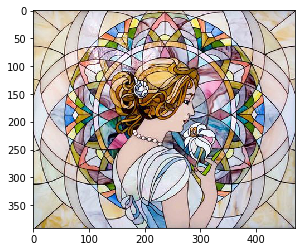

In [6]:
plt.imshow(recover_image(style_img_tensor.cpu().numpy())[0])

Precalculate gram matrices of the style image:

In [7]:
# http://pytorch.org/docs/master/notes/autograd.html#volatile
with torch.no_grad():
    style_loss_features = loss_network(style_img_tensor)
    gram_style = [gram_matrix(y) for y in style_loss_features]

In [8]:
style_loss_features._fields

('relu1_2', 'relu2_2', 'relu3_3', 'relu4_3')

In [9]:
for i in range(len(style_loss_features)):
    print(i, np.mean(gram_style[i].cpu().numpy()))

0 0.017494678
1 0.02093872
2 0.010261788
3 0.00035839574


In [10]:
for i in range(len(style_loss_features)):
    print(i, np.mean(style_loss_features[i].cpu().numpy()))

0 0.90219545
1 1.4948839
2 1.5104407
3 0.39363515


In [11]:
for i in range(len(style_loss_features)):
    print(i, gram_style[i].numel(), gram_style[i].size())

0 4096 torch.Size([1, 64, 64])
1 16384 torch.Size([1, 128, 128])
2 65536 torch.Size([1, 256, 256])
3 262144 torch.Size([1, 512, 512])


## Train the Transformer / Image Generator
Utility function to save debug images during training:

In [12]:
def save_debug_image(tensor_orig, tensor_transformed, tensor_with_noise, filename):
    assert tensor_orig.size() == tensor_transformed.size()
    result = Image.fromarray(recover_image(tensor_transformed.cpu().numpy())[0])
    noise = Image.fromarray(recover_image(tensor_with_noise.cpu().numpy())[0])
    orig = Image.fromarray(recover_image(tensor_orig.cpu().numpy())[0])
    new_im = Image.new('RGB', (result.size[0] * 3 + 10, result.size[1]))
    new_im.paste(orig, (0,0))
    new_im.paste(result, (result.size[0] + 5,0))
    new_im.paste(noise, (result.size[0] * 2 + 10,0))
    new_im.save(filename)

In [13]:
%mkdir -p ../debug

In [14]:
transformer = TransformerNet()
mse_loss = torch.nn.MSELoss()
# l1_loss = torch.nn.L1Loss()
transformer.to(device)

TransformerNet(
  (conv1): ConvLayer(
    (reflection_pad): ReflectionPad2d((4, 4, 4, 4))
    (conv2d): Conv2d(3, 32, kernel_size=(9, 9), stride=(1, 1))
  )
  (in1): InstanceNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=False)
  (conv2): ConvLayer(
    (reflection_pad): ReflectionPad2d((1, 1, 1, 1))
    (conv2d): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2))
  )
  (in2): InstanceNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=False)
  (conv3): ConvLayer(
    (reflection_pad): ReflectionPad2d((1, 1, 1, 1))
    (conv2d): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2))
  )
  (in3): InstanceNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=False)
  (res1): ResidualBlock(
    (conv1): ConvLayer(
      (reflection_pad): ReflectionPad2d((1, 1, 1, 1))
      (conv2d): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1))
    )
    (in1): InstanceNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=False)
    (

In [15]:
CONTENT_WEIGHT = 1
STYLE_WEIGHTS = np.array([1e4, 1e4, 1e3, 1e3]) * 2
REGULARIZATION = 1e-6
NOISE_P = 0.1
NOISE_STD = 0.5
NOISE_WEIGHT = 10 * 2
LOG_INTERVAL = 50

LR = 1e-3
optimizer = Adam(transformer.parameters(), LR)

torch.set_default_tensor_type('torch.FloatTensor')
    
def train(steps, base_steps=0):
    transformer.train()
    count = 0
    agg_content_loss = 0.
    agg_style_loss = 0.
    agg_reg_loss = 0.   
    agg_stable_loss = 0.
    while True:
        for x, _ in train_loader:
            count += 1
            optimizer.zero_grad()
            x = x.to(device)             
            y = transformer(x)            
            with torch.no_grad():                      
                mask = torch.bernoulli(torch.ones_like(
                    x, device=device, dtype=torch.float
                ) * NOISE_P)
                noise = torch.normal(
                    torch.zeros_like(x), 
                    torch.ones_like(
                        x, device=device, dtype=torch.float
                    ) * NOISE_STD
                ).clamp(-1, 1)
                # print((noise * mask).sum())
            y_noise = transformer(x + noise * mask)
                        
            with torch.no_grad():
                xc = x.detach()

            features_y = loss_network(y)
            features_xc = loss_network(xc)

            with torch.no_grad():
                f_xc_c = features_xc[1].detach()

            content_loss = CONTENT_WEIGHT * mse_loss(features_y[1], f_xc_c)

            reg_loss = REGULARIZATION * (
                torch.sum(torch.abs(y[:, :, :, :-1] - y[:, :, :, 1:])) + 
                torch.sum(torch.abs(y[:, :, :-1, :] - y[:, :, 1:, :])))

            style_loss = 0.
            for l, weight in enumerate(STYLE_WEIGHTS):
                gram_s = gram_style[l]
                gram_y = gram_matrix(features_y[l])
                style_loss += float(weight) * mse_loss(gram_y, gram_s.expand_as(gram_y))
                
            stability_loss = NOISE_WEIGHT * mse_loss(y_noise.view(-1), y.view(-1).detach())

            total_loss = content_loss + style_loss + reg_loss + stability_loss
            total_loss.backward()
            optimizer.step()

            agg_content_loss += content_loss
            agg_style_loss += style_loss
            agg_reg_loss += reg_loss
            agg_stable_loss += stability_loss

            if count % LOG_INTERVAL == 0:
                mesg = "{} [{}/{}] content: {:.2f}  style: {:.2f}  reg: {:.2f} stable: {:.2f} total: {:.6f}".format(
                            time.ctime(), count, steps,
                            agg_content_loss / LOG_INTERVAL,
                            agg_style_loss / LOG_INTERVAL,
                            agg_reg_loss / LOG_INTERVAL,
                            agg_stable_loss / LOG_INTERVAL,
                            (agg_content_loss + agg_style_loss + 
                             agg_reg_loss + agg_stable_loss) / LOG_INTERVAL
                        )
                print(mesg)
                agg_content_loss = 0.
                agg_style_loss = 0.
                agg_reg_loss = 0.
                agg_stable_loss = 0.
                transformer.eval()
                y = transformer(x)
                save_debug_image(x, y.detach(), y_noise.detach(), "../debug/{}.png".format(base_steps + count))
                transformer.train()
                
            if count >= steps:
                return

In [16]:
len(train_loader)

10168

In [17]:
train(1000, 0)

Thu Jun 21 09:59:16 2018 [50/1000] content: 7.03  style: 37.93  reg: 0.07 stable: 0.04 total: 45.074242
Thu Jun 21 09:59:55 2018 [100/1000] content: 9.70  style: 21.05  reg: 0.19 stable: 0.06 total: 30.998991
Thu Jun 21 10:00:35 2018 [150/1000] content: 11.47  style: 10.30  reg: 0.33 stable: 0.25 total: 22.352045
Thu Jun 21 10:01:15 2018 [200/1000] content: 11.67  style: 6.28  reg: 0.36 stable: 0.33 total: 18.644487
Thu Jun 21 10:01:54 2018 [250/1000] content: 11.57  style: 4.70  reg: 0.38 stable: 0.25 total: 16.904039
Thu Jun 21 10:02:34 2018 [300/1000] content: 11.30  style: 3.99  reg: 0.39 stable: 0.31 total: 15.991159
Thu Jun 21 10:03:13 2018 [350/1000] content: 11.01  style: 3.62  reg: 0.39 stable: 0.30 total: 15.321651
Thu Jun 21 10:03:53 2018 [400/1000] content: 10.80  style: 3.34  reg: 0.40 stable: 0.27 total: 14.810892
Thu Jun 21 10:04:32 2018 [450/1000] content: 10.60  style: 3.19  reg: 0.40 stable: 0.30 total: 14.484126
Thu Jun 21 10:05:12 2018 [500/1000] content: 10.49  sty

In [18]:
troptimizer = Adam(transformer.parameters(), LR * 0.5)

In [19]:
train(3000, 1000)

Thu Jun 21 10:12:27 2018 [50/3000] content: 8.85  style: 2.59  reg: 0.40 stable: 0.41 total: 12.248878
Thu Jun 21 10:13:07 2018 [100/3000] content: 8.70  style: 2.49  reg: 0.41 stable: 0.41 total: 12.001401
Thu Jun 21 10:13:46 2018 [150/3000] content: 8.61  style: 2.57  reg: 0.40 stable: 0.42 total: 11.995880
Thu Jun 21 10:14:26 2018 [200/3000] content: 8.64  style: 2.50  reg: 0.39 stable: 0.43 total: 11.956182
Thu Jun 21 10:15:05 2018 [250/3000] content: 8.53  style: 2.54  reg: 0.40 stable: 0.44 total: 11.906215
Thu Jun 21 10:15:45 2018 [300/3000] content: 8.43  style: 2.46  reg: 0.39 stable: 0.43 total: 11.715103
Thu Jun 21 10:16:25 2018 [350/3000] content: 8.47  style: 2.55  reg: 0.39 stable: 0.42 total: 11.828168
Thu Jun 21 10:17:04 2018 [400/3000] content: 8.25  style: 2.49  reg: 0.40 stable: 0.44 total: 11.575696
Thu Jun 21 10:17:43 2018 [450/3000] content: 8.30  style: 2.54  reg: 0.40 stable: 0.46 total: 11.694118
Thu Jun 21 10:18:23 2018 [500/3000] content: 8.38  style: 2.49  r

In [20]:
save_model_path = "../models/mosaic_4000.pth"
torch.save(transformer.state_dict(), save_model_path)

In [21]:
optimizer = Adam(transformer.parameters(), LR * 0.1)

In [22]:
LOG_INTERVAL = 100
train(6000, 4000)

Thu Jun 21 10:53:01 2018 [100/6000] content: 6.91  style: 2.26  reg: 0.39 stable: 0.68 total: 10.235847
Thu Jun 21 10:54:20 2018 [200/6000] content: 6.88  style: 2.23  reg: 0.39 stable: 0.68 total: 10.170286
Thu Jun 21 10:55:39 2018 [300/6000] content: 6.76  style: 2.22  reg: 0.39 stable: 0.66 total: 10.029805
Thu Jun 21 10:56:58 2018 [400/6000] content: 6.73  style: 2.18  reg: 0.39 stable: 0.67 total: 9.962064
Thu Jun 21 10:58:16 2018 [500/6000] content: 6.81  style: 2.20  reg: 0.39 stable: 0.76 total: 10.153763
Thu Jun 21 10:59:35 2018 [600/6000] content: 6.81  style: 2.21  reg: 0.39 stable: 0.73 total: 10.130036
Thu Jun 21 11:00:54 2018 [700/6000] content: 6.72  style: 2.18  reg: 0.39 stable: 0.71 total: 9.995344
Thu Jun 21 11:02:13 2018 [800/6000] content: 6.66  style: 2.18  reg: 0.39 stable: 0.68 total: 9.916314
Thu Jun 21 11:03:31 2018 [900/6000] content: 6.83  style: 2.18  reg: 0.39 stable: 0.74 total: 10.141972
Thu Jun 21 11:04:50 2018 [1000/6000] content: 6.82  style: 2.23  re

In [23]:
save_model_path = "../models/mosaic_10000.pth"
torch.save(transformer.state_dict(), save_model_path)

In [24]:
import glob
fnames = glob.glob(DATASET + r"/*/*")
len(fnames)

40670

In [25]:
transformer = transformer.eval()

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  # Remove the CWD from sys.path while we load stuff.


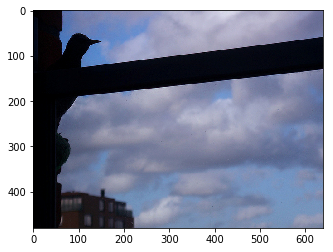

In [26]:
img = Image.open(fnames[40]).convert('RGB')
transform = transforms.Compose([
                                
                                transforms.ToTensor(),
                                tensor_normalizer()])
img_tensor = transform(img).unsqueeze(0)
if torch.cuda.is_available():
    img_tensor = img_tensor.cuda()

img_output = transformer(Variable(img_tensor, volatile=True))
plt.imshow(recover_image(img_tensor.cpu().numpy())[0])

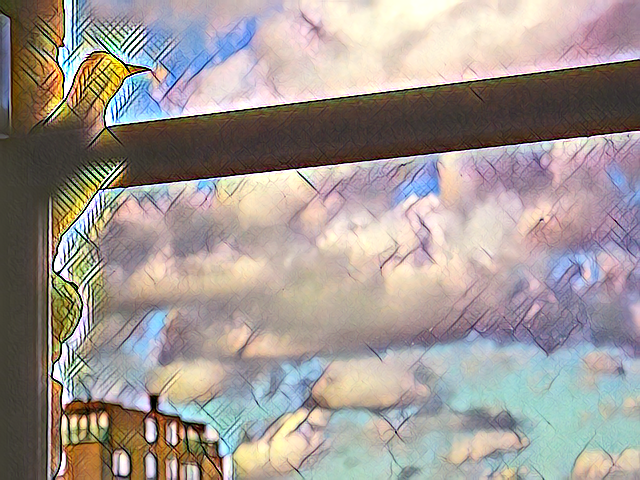

In [27]:
Image.fromarray(recover_image(img_output.data.cpu().numpy())[0])

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  # Remove the CWD from sys.path while we load stuff.


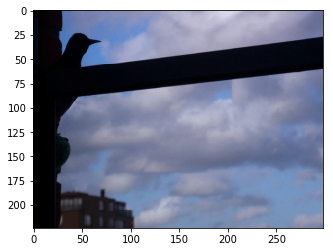

In [28]:
img = Image.open(fnames[40]).convert('RGB')
transform = transforms.Compose([
                                transforms.Resize(IMAGE_SIZE),
                                transforms.ToTensor(),
                                tensor_normalizer()])
img_tensor = transform(img).unsqueeze(0)
if torch.cuda.is_available():
    img_tensor = img_tensor.cuda()

img_output = transformer(Variable(img_tensor, volatile=True))
plt.imshow(recover_image(img_tensor.cpu().numpy())[0])

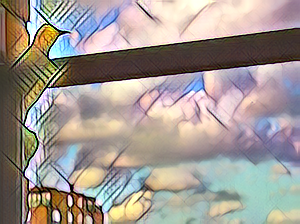

In [29]:
Image.fromarray(recover_image(img_output.data.cpu().numpy())[0])

torch.Size([1, 3, 512, 512])


/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  # This is added back by InteractiveShellApp.init_path()


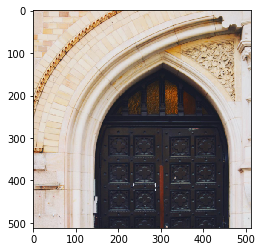

In [30]:
img = Image.open("../content_images/amber.jpg").convert('RGB')
transform = transforms.Compose([
    transforms.Resize(512),
    transforms.ToTensor(),
    tensor_normalizer()])
img_tensor = transform(img).unsqueeze(0)
print(img_tensor.size())
if torch.cuda.is_available():
    img_tensor = img_tensor.cuda()

img_output = transformer(Variable(img_tensor, volatile=True))
plt.imshow(recover_image(img_tensor.cpu().numpy())[0])

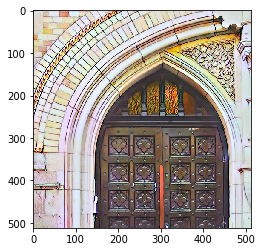

In [31]:
plt.imshow(recover_image(img_output.data.cpu().numpy())[0])

torch.Size([1, 3, 224, 224])


/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  # This is added back by InteractiveShellApp.init_path()


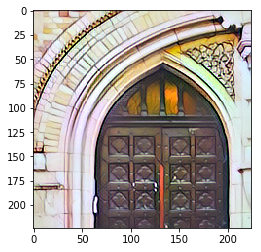

In [32]:
img = Image.open("../content_images/amber.jpg").convert('RGB')
transform = transforms.Compose([
    transforms.Resize(224),
    transforms.ToTensor(),
    tensor_normalizer()])
img_tensor = transform(img).unsqueeze(0)
print(img_tensor.size())
if torch.cuda.is_available():
    img_tensor = img_tensor.cuda()

img_output = transformer(Variable(img_tensor, volatile=True))
plt.imshow(recover_image(img_output.data.cpu().numpy())[0])

In [33]:
output_img = Image.fromarray(recover_image(img_output.data.cpu().numpy())[0])
output_img.save("amber.png")